# Supplement vs placebo 

The data consists of 112 girls randomized to receive calcium or placebo. The response variable consists of longitudinal measurements of **bone mineral density (g/cm²)** measured approximately every 6 months for 3 years. All girls are approximately 11 years old at the start of the trial.  

The main variables are:

- **bmd**: bone mass density  
- **group**: placebo or supplement  
- **person**: factor indicating the ID of each girl  
- **age**: the age of each girl at the time of each measurement  



In [1]:
from pymgcv.basis_functions import RandomEffect
from pymgcv.gam import GAM
from pymgcv.terms import L, S
from pymgcv.utils import load_rdata_dataframe_from_url

data = load_rdata_dataframe_from_url(
    "https://github.com/mfasiolo/testGam/raw/master/data/calcium.rda",
)
data["group"] = data["group"].astype("category")
data["person"] = data["person"].astype("category")

- Let's create a naive model, not taking into account differences between individuals.

In [2]:
gam = GAM({"bmd": L("group") + L("age")})
gam.fit(data)
print(gam.summary())


Family: gaussian 
Link function: identity 

Formula:
bmd ~ group + age + 1

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.337882   0.051553   6.554  1.4e-10 ***
groupP      -0.019539   0.006055  -3.227  0.00133 ** 
age          0.049501   0.004282  11.560  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


R-sq.(adj) =  0.221   Deviance explained = 22.4%
-REML = -625.72  Scale est. = 0.004589  n = 501


- The placebo has a negative effect, as you would expect if the treatment works
- Let's add a [`RandomEffect`][pymgcv.basis_functions.RandomEffect] for each subject

In [3]:
gam = GAM({"bmd": L("group") + L("age") + S("person", bs=RandomEffect())}, add_intercepts=False)
gam.fit(data)
print(gam.summary())


Family: gaussian 
Link function: identity 

Formula:
bmd ~ group + age + s(person, bs = "re") - 1

Parametric coefficients:
       Estimate Std. Error t value Pr(>|t|)    
groupC 0.329263   0.015168   21.71   <2e-16 ***
groupP 0.309940   0.015079   20.55   <2e-16 ***
age    0.050217   0.001017   49.39   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df     F p-value    
s(person) 108.4    110 82.75  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.96   Deviance explained = 96.9%
-REML = -1121.3  Scale est. = 0.00023803  n = 501


- The metrics look much better. Obviously individual differences should be taken into account

Let's consider a non-linear age component, and compare AICs

In [4]:
non_lin_gam = GAM({"bmd": L("group") + S("age") + S("person", bs=RandomEffect())})
non_lin_gam.fit(data)


models = {
    "linear age": gam,
    "non-linear age": non_lin_gam,
}
for name, model in models.items():
    print(f"{name}: AIC={model.aic()}")

linear age: AIC=-2659.2059601610404
non-linear age: AIC=-2658.1008821828736


- Very similar AICs, hard to say!

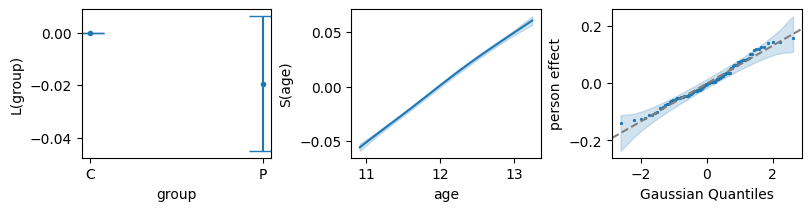

In [5]:
import pymgcv.plot as gplt

fig, ax = gplt.plot(non_lin_gam, ncols=3)
fig.set_size_inches(8, 2)